## CNN Classifier Experiments with MNIST
A typical CNN classifier for MNIST. Could makes 99% in both train and validation set

In [1]:
import gzip
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
# Shuffle arrays or sparse matrices in a consistent way
from sklearn.utils import shuffle

## Data Loading and Plotting

In [2]:
dataPath='../dataset/MNIST_data/'
mnist = input_data.read_data_sets(dataPath, one_hot=True)

Extracting ../dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# read the images and reformat the image shape from [img_num,img_height,img_width] to [img_num,img_height,img_width,1]
img_width = 28
img_height = 28
images = mnist.train.images

In [4]:
# read the labels, 6 --> class 0; 9 --> class 1
y1hot_all = mnist.train.labels
y_all = np.argmax(y1hot_all,axis=1)
idx6 = np.nonzero(y_all==6)[0]
idx9 = np.nonzero(y_all==9)[0]
idx69 = np.concatenate([idx6, idx9])
print('Having {} and {} for 6 and 9 respectively'.format(len(idx6),len(idx9)))
y = np.copy(y_all)
y[idx6] = 0
y[idx9] = 1
y = y[idx69]
y = y[...,np.newaxis]
y1hot = [[int(x[6]), int(x[9])] for x in y1hot_all[idx69]]

Having 5417 and 5454 for 6 and 9 respectively


In [5]:
allidx = set(range(len(y_all)))
restidx = list(set.difference(allidx,set(idx69)))
#print(len(restidx),len(idx69),len(allidx))
#assert(len(restidx)+len(idx69)==len(allidx))
y1hot_rest_flip = [[1, 0] for x in y1hot_all[restidx]]
#print(len(y1hot_rest_flip))

In [6]:
# read the images and reformat the image shape from [img_num,img_height,img_width] to [img_num,img_height,img_width,1]
# extract 6, 9 as training images. The rest of images are for unsupervised training
n_classes = 2
x = images[idx69]
x_num, _ = x.shape
assert(len(x)==len(y))
x = np.reshape(x,(x_num,img_height,img_width))
x = x[...,np.newaxis]
print('(Input to CNN) Images with shape {}'.format(x.shape))
restidx = list( set.difference( set(range(len(images))), set(idx69) ) )
assert(len(restidx)+len(x)==len(images))
x_rest = images[restidx]
x_rest_num, _ = x_rest.shape
x_rest = np.reshape(x_rest,(x_rest_num,img_height,img_width))
x_rest = x_rest[...,np.newaxis]
print('(Input to CNN) Rest of Images with shape {}'.format(x_rest.shape))

(Input to CNN) Images with shape (10871, 28, 28, 1)
(Input to CNN) Rest of Images with shape (44129, 28, 28, 1)


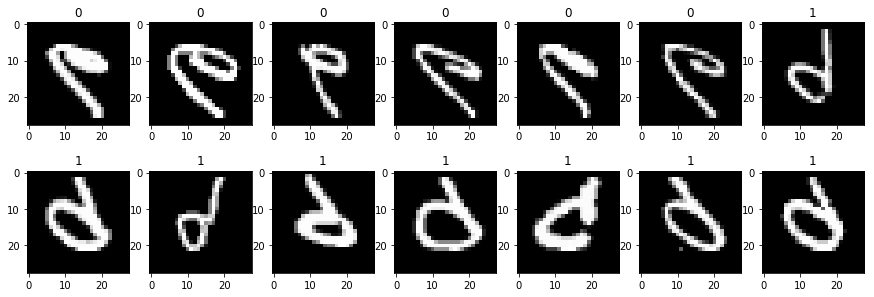

In [7]:
# generate testing input as flipping upside down images to training data
y1hot_flip = np.copy(y1hot)
y_flip = np.copy(y)
def flip(img):
    rtnimg = np.array([img[img_height-1-i,...] for i in range(img_height)])
    return rtnimg
x_flip = list(map(lambda img: flip(img),x))
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    plt.subplot(2,7,i+1)
    plt.imshow(x_flip[5411+i][...,0],cmap='gray')
    plt.title(y_flip[5411+i][0])
    
x_rest_flip = list(map(lambda img: flip(img),x_rest))

## CNN Graph Construction

1. Define the input output tensors
2. Define the graph and construct it
3. Define the loss and optimizer

### First define the hyper-parameters

In [8]:
# Hyper-parameters
EPOCHS = 3
EPOCHS_TF = 10
BATCH_SIZE = 128
rate = 0.001
drop_out_keep_prob = 0.5

### Define the input output tensors

In [9]:
# using one-hot decoding
cNum = 1
x_feed = tf.placeholder(tf.float32, (None, img_height, img_width, cNum))
one_hot_y_feed = tf.placeholder(tf.int32, (None, n_classes))

x_feed_student = tf.placeholder(tf.float32, (None, img_height, img_width, cNum))
one_hot_y_feed_student = tf.placeholder(tf.int32, (None, n_classes))
#one_hot_y = tf.one_hot(y, n_classes)

### Define the graph and construct it

In [10]:
kSize = 5
mu = 0
sigma = 0.1
layer_depth = {
    'layer_1': 16,
    'layer_2': 32,
    'fully_connected_1': 256,
    'fully_connected_2': 128,
    'out': n_classes,
}
keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [11]:
# CNN architecture

with tf.variable_scope('teacher'):
    weights = {
        'layer_1': tf.get_variable('layer_1w', shape=(kSize, kSize, cNum, layer_depth['layer_1']),initializer=tf.random_normal_initializer(mu,sigma)),
        'layer_2': tf.get_variable('layer_2w', shape=(kSize, kSize, layer_depth['layer_1'], layer_depth['layer_2']),initializer=tf.random_normal_initializer(mu,sigma)),
        'fully_connected_1': tf.get_variable('fully_connected_1w', shape=(4*4*layer_depth['layer_2'], layer_depth['fully_connected_1']),initializer=tf.random_normal_initializer(mu,sigma)),
        'fully_connected_2': tf.get_variable('fully_connected_2w', shape=(layer_depth['fully_connected_1'], layer_depth['fully_connected_2']),initializer=tf.random_normal_initializer(mu,sigma)),
        'out': tf.get_variable('outw', shape=(layer_depth['fully_connected_2'], layer_depth['out']),initializer=tf.random_normal_initializer(mu,sigma))
    }
    #+0.3 over the first epochs than +-0

    biases = {
        'layer_1': tf.get_variable('layer_1b', shape=(layer_depth['layer_1']),initializer=tf.zeros_initializer),
        'layer_2': tf.get_variable('layer_2b', shape=(layer_depth['layer_2']),initializer=tf.zeros_initializer),
        'fully_connected_1': tf.get_variable('fully_connected_1b', shape=(layer_depth['fully_connected_1']),initializer=tf.zeros_initializer),
        'fully_connected_2': tf.get_variable('fully_connected_2b', shape=(layer_depth['fully_connected_2']),initializer=tf.zeros_initializer),
        'out': tf.get_variable('outb', shape=(layer_depth['out']),initializer=tf.zeros_initializer)
    }

def CNNMNIST_teacher(x):
    # Layer 1: Convolutional. Input = 28x28xcNum. Output = 24x24xlayer_depth['layer_1'].
    conv1   = tf.nn.conv2d(x, weights['layer_1'], strides=[1, 1, 1, 1], padding='VALID') + biases['layer_1']
    print('conv1 has shape=',conv1.shape)

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 24x24xlayer_depth['layer_1']. Output = 12x12xlayer_depth['layer_1'].
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 8x8xlayer_depth['layer_2'].
    conv2   = tf.nn.conv2d(conv1, weights['layer_2'], strides=[1, 1, 1, 1], padding='VALID') + biases['layer_2']
    print('conv2 has shape=',conv2.shape)

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 8x8xlayer_depth['layer_2']. Output = 4x4xlayer_depth['layer_2'].
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 4x4xlayer_depth['layer_2']. Output = 4x4xlayer_depth['layer_2'].
    print('flatten(conv2) has shape=',flatten(conv2).shape)
    #print('flatten(conv1) has shape=',tf.shape(flatten(conv1)))
    #fc0   = tf.concat(1,[flatten(conv2), flatten(conv1)])
    fc0 = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 5x5xlayer_depth['layer_2']. Output = layer_depth['fully_connected_1'].
    fc1   = tf.matmul(fc0, weights['fully_connected_1']) + biases['fully_connected_1']

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)    # dropout

    # SOLUTION: Layer 4: Fully Connected. Input = layer_depth['fully_connected_1']. Output = layer_depth['fully_connected_2'].
    fc2    = tf.matmul(fc1, weights['fully_connected_2']) + biases['fully_connected_2']
    fc2 = tf.nn.dropout(fc2, keep_prob)    # dropout

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = layer_depth['fully_connected_2']. Output = layer_depth['out'].
    logits = tf.matmul(fc2, weights['out']) + biases['out']
    print('logits has shape=',logits.shape)
    return logits

logits = CNNMNIST_teacher(x_feed)

conv1 has shape= (?, 24, 24, 16)
conv2 has shape= (?, 8, 8, 32)
flatten(conv2) has shape= (?, 512)
logits has shape= (?, 2)


In [12]:
with tf.variable_scope('student'):
    weights_student = {
        'permutation': tf.get_variable('permutation',shape=(img_height,img_width),trainable=True),
        'layer_1': tf.get_variable('layer_1w', shape=(kSize, kSize, cNum, layer_depth['layer_1']), initializer=tf.random_normal_initializer(mu,sigma), trainable=False),
        'layer_2': tf.get_variable('layer_2w', shape=(kSize, kSize, layer_depth['layer_1'], layer_depth['layer_2']), initializer=tf.random_normal_initializer(mu,sigma), trainable=False),
        'fully_connected_1': tf.get_variable('fully_connected_1w', shape=(4*4*layer_depth['layer_2'], layer_depth['fully_connected_1']), initializer=tf.random_normal_initializer(mu,sigma), trainable=False),
        'fully_connected_2': tf.get_variable('fully_connected_2w', shape=(layer_depth['fully_connected_1'], layer_depth['fully_connected_2']), initializer=tf.random_normal_initializer(mu,sigma), trainable=False),
        'out': tf.get_variable('outw', shape=(layer_depth['fully_connected_2'], layer_depth['out']), initializer=tf.random_normal_initializer(mu,sigma), trainable=False)
    }
    #+0.3 over the first epochs than +-0

    biases_student = {
        'layer_1': tf.get_variable('layer_1b', shape=(layer_depth['layer_1']),\
                                   initializer=tf.zeros_initializer, trainable=False),
        'layer_2': tf.get_variable('layer_2b', shape=(layer_depth['layer_2']),\
                                   initializer=tf.zeros_initializer, trainable=False),
        'fully_connected_1': tf.get_variable('fully_connected_1b', shape=(layer_depth['fully_connected_1']),\
                                             initializer=tf.zeros_initializer, trainable=False),
        'fully_connected_2': tf.get_variable('fully_connected_2b', shape=(layer_depth['fully_connected_2']),\
                                             initializer=tf.zeros_initializer, trainable=False),
        'out': tf.get_variable('outb', shape=(layer_depth['out']),initializer=tf.zeros_initializer, trainable=False)
    }


In [13]:
trainable_collection_t = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='teacher')
global_collection_t = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='teacher')
print('Without Scope: len(trainable_collection_t)={}; len(global_collection_t)={}'.format(len(trainable_collection_t),len(global_collection_t)))

trainable_collection_s = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='student')
global_collection_s = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='student')
print('Without Scope: len(trainable_collection_s)={}; len(global_collection_s)={}'.format(len(trainable_collection_s),len(global_collection_s)))

trainable_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
global_collection = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print('Without Scope: len(trainable_collection)={}; len(global_collection)={}'.format(len(trainable_collection),len(global_collection)))

Without Scope: len(trainable_collection_t)=10; len(global_collection_t)=10
Without Scope: len(trainable_collection_s)=1; len(global_collection_s)=11
Without Scope: len(trainable_collection)=11; len(global_collection)=21


In [14]:
print(trainable_collection_t)
print('\n')
print(trainable_collection_s)

[<tf.Variable 'teacher/layer_1w:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'teacher/layer_2w:0' shape=(5, 5, 16, 32) dtype=float32_ref>, <tf.Variable 'teacher/fully_connected_1w:0' shape=(512, 256) dtype=float32_ref>, <tf.Variable 'teacher/fully_connected_2w:0' shape=(256, 128) dtype=float32_ref>, <tf.Variable 'teacher/outw:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'teacher/layer_1b:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'teacher/layer_2b:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'teacher/fully_connected_1b:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'teacher/fully_connected_2b:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'teacher/outb:0' shape=(2,) dtype=float32_ref>]


[<tf.Variable 'student/permutation:0' shape=(28, 28) dtype=float32_ref>]


In [15]:
def CNNMNIST_student(x):
    bsize = tf.shape(x)[0]
    # processing the permutation matrix
    #x = tf.squeeze(x) # (batch_sizex28x28)
    x = tf.reshape(x,shape=(bsize,img_height,img_width))
    permutation = tf.tile(tf.expand_dims(weights_student['permutation'],0),[bsize,1,1])
    print(permutation.shape)
    x = tf.matmul(permutation,x) # (batchsizex28x28)
    x = tf.expand_dims(x,-1) # (batchsizex28x28x1)
    
    after_permute_x = x
    
    # Layer 1: Convolutional. Input = 28x28xcNum. Output = 24x24xlayer_depth['layer_1'].
    conv1   = tf.nn.conv2d(x, weights_student['layer_1'], strides=[1, 1, 1, 1], padding='VALID') + biases_student['layer_1']
    print('conv1 has shape=',conv1.shape)

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 24x24xlayer_depth['layer_1']. Output = 12x12xlayer_depth['layer_1'].
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 8x8xlayer_depth['layer_2'].
    conv2   = tf.nn.conv2d(conv1, weights_student['layer_2'], strides=[1, 1, 1, 1], padding='VALID') + biases_student['layer_2']
    print('conv2 has shape=',conv2.shape)

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 8x8xlayer_depth['layer_2']. Output = 4x4xlayer_depth['layer_2'].
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 4x4xlayer_depth['layer_2']. Output = 4x4xlayer_depth['layer_2'].
    print('flatten(conv2) has shape=',flatten(conv2).shape)
    #print('flatten(conv1) has shape=',tf.shape(flatten(conv1)))
    #fc0   = tf.concat(1,[flatten(conv2), flatten(conv1)])
    fc0 = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 5x5xlayer_depth['layer_2']. Output = layer_depth['fully_connected_1'].
    fc1   = tf.matmul(fc0, weights_student['fully_connected_1']) + biases_student['fully_connected_1']

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)    # dropout

    # SOLUTION: Layer 4: Fully Connected. Input = layer_depth['fully_connected_1']. Output = layer_depth['fully_connected_2'].
    fc2    = tf.matmul(fc1, weights_student['fully_connected_2']) + biases_student['fully_connected_2']
    fc2 = tf.nn.dropout(fc2, keep_prob)    # dropout

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = layer_depth['fully_connected_2']. Output = layer_depth['out'].
    logits = tf.matmul(fc2, weights_student['out']) + biases_student['out']
    print('logits has shape=',logits.shape)
    return logits, after_permute_x

logits_student, after_permute_x = CNNMNIST_student(x_feed_student)

(?, 28, 28)
conv1 has shape= (?, 24, 24, 16)
conv2 has shape= (?, 8, 8, 32)
flatten(conv2) has shape= (?, 512)
logits has shape= (?, 2)


### Define loss and optimizer

In [16]:
# Define loss, optimizer
# softmax_cross_entropy_with_logits: https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# labels: Each row labels[i] must be a valid probability distribution.
# logits: Unscaled log probabilities.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y_feed,logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

loss_tf_op = tf.nn.l2_loss(logits_student-logits)
optimizer_tf = tf.train.AdamOptimizer(learning_rate = rate)
training_tf_operation = optimizer_tf.minimize(loss_tf_op, var_list = trainable_collection_s)

In [17]:
# Define accuracy evaluation
# calculate the average accuracy by calling evaluate(X_data, y_data)
correct_prediction = tf.equal(tf.argmax(logits, axis=1), tf.argmax(one_hot_y_feed, axis=1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    assert(len(X_data)==len(y_data))
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x_feed: batch_x, one_hot_y_feed: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

correct_prediction_student = tf.equal(tf.argmax(logits_student, axis=1), tf.argmax(one_hot_y_feed_student, axis=1))
accuracy_operation_student = tf.reduce_mean(tf.cast(correct_prediction_student, tf.float32))
def evaluate_student(X_data, y_data):
    num_examples = len(X_data)
    assert(len(X_data)==len(y_data))
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation_student, feed_dict={x_feed_student: batch_x, one_hot_y_feed_student: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Run Session

In [18]:
### Train your model here.
# mini-batch Adam training, will save model as ./models/mnist-cnn-model
if not os.path.isdir('./models'):
    os.makedirs('./models')
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = x_num
    
    print("Training...")
    print()
    train_accuracy = np.zeros(EPOCHS)
    flip_accuracy = np.zeros(EPOCHS)
    for i in range(EPOCHS):
        acc_train_accuracy = 0
        X_train, y_train = shuffle(x, y1hot)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_feed: batch_x, one_hot_y_feed: batch_y, keep_prob: drop_out_keep_prob})
            acc_train_accuracy += evaluate(batch_x, batch_y)
        train_accuracy[i] = acc_train_accuracy/len(range(0, num_examples, BATCH_SIZE))
        flip_accuracy[i] = evaluate(x_flip, y1hot_flip)
        print("EPOCH {} ...".format(i+1))
        #print("Train Accuracy = {:.3f}".format(train_accuracy[i]))
        print("Train Accuracy = {:.3f}; Flip Accuracy = {:.3f}".format(train_accuracy[i],flip_accuracy[i]))
        print()
    
    """
    We Then Do the Copy from Teacher to Student Models
    """
    print('Before assignment')
    #print(sess.run(weights_student['layer_1']))
    sess.run(weights_student['layer_1'].assign(weights['layer_1']))
    sess.run(weights_student['layer_2'].assign(weights['layer_2']))
    sess.run(weights_student['fully_connected_1'].assign(weights['fully_connected_1']))
    sess.run(weights_student['fully_connected_2'].assign(weights['fully_connected_2']))
    sess.run(weights_student['out'].assign(weights['out']))
    sess.run(biases_student['layer_1'].assign(biases['layer_1']))
    sess.run(biases_student['layer_2'].assign(biases['layer_2']))
    sess.run(biases_student['fully_connected_1'].assign(biases['fully_connected_1']))
    sess.run(biases_student['fully_connected_2'].assign(biases['fully_connected_2']))
    sess.run(biases_student['out'].assign(biases['out']))
    print('After assignment')
    #print(sess.run(weights_student['layer_1']))
    
    """
    Using Flipped Images to Unsupervised Training the Original Net
    """
    train_accuracy_tf = np.zeros(EPOCHS_TF)
    flip_accuracy_tf = np.zeros(EPOCHS_TF)
    for i in range(EPOCHS_TF):
        acc_loss = 0.0
        X_train, X_train_flip = shuffle(x_rest, x_rest_flip)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x = X_train[offset:end]
            batch_x_flip = X_train_flip[offset:end]
            _, l = sess.run([training_tf_operation, loss_tf_op], feed_dict={x_feed: batch_x,\
                                                                            x_feed_student: batch_x_flip,\
                                                                            keep_prob: 1.0})
            #print('Current loss in batch = {}'.format(l))
            acc_loss += l
        acc_loss /= num_examples
        #train_accuracy_tf[i] = evaluate(x, y1hot)
        train_accuracy_tf[i] = evaluate_student(x, y1hot)
        flip_accuracy_tf[i] = evaluate_student(x_flip, y1hot_flip)
        print("EPOCH {} ...".format(i+1))
        print("Acc loss = {}".format(acc_loss))
        print("Train Accuracy = {:.3f}; Flip Accuracy = {:.3f}".format(train_accuracy_tf[i],flip_accuracy_tf[i]))
        print()
    saver.save(sess, './models/mnist-cnn-model')
    print("Model saved")
    

Training...

EPOCH 1 ...
Train Accuracy = 0.986; Flip Accuracy = 0.065

EPOCH 2 ...
Train Accuracy = 0.999; Flip Accuracy = 0.083

EPOCH 3 ...
Train Accuracy = 0.999; Flip Accuracy = 0.093

Before assignment
After assignment
EPOCH 1 ...
Acc loss = 5.615970120655011
Train Accuracy = 0.279; Flip Accuracy = 0.947

EPOCH 2 ...
Acc loss = 1.9494884885034043
Train Accuracy = 0.208; Flip Accuracy = 0.990

EPOCH 3 ...
Acc loss = 1.4512659598708362
Train Accuracy = 0.175; Flip Accuracy = 0.996

EPOCH 4 ...
Acc loss = 1.1984122196211897
Train Accuracy = 0.148; Flip Accuracy = 0.997

EPOCH 5 ...
Acc loss = 1.0114140402216907
Train Accuracy = 0.152; Flip Accuracy = 0.997

EPOCH 6 ...
Acc loss = 0.8944660004647453
Train Accuracy = 0.141; Flip Accuracy = 0.997

EPOCH 7 ...
Acc loss = 0.8054127535707278
Train Accuracy = 0.133; Flip Accuracy = 0.997

EPOCH 8 ...
Acc loss = 0.7411507803101338
Train Accuracy = 0.132; Flip Accuracy = 0.997

EPOCH 9 ...
Acc loss = 0.7160771973228929
Train Accuracy = 0.126

### We then checkout the permutation matrix !

INFO:tensorflow:Restoring parameters from ./models\mnist-cnn-model
(10871, 28, 28, 1)


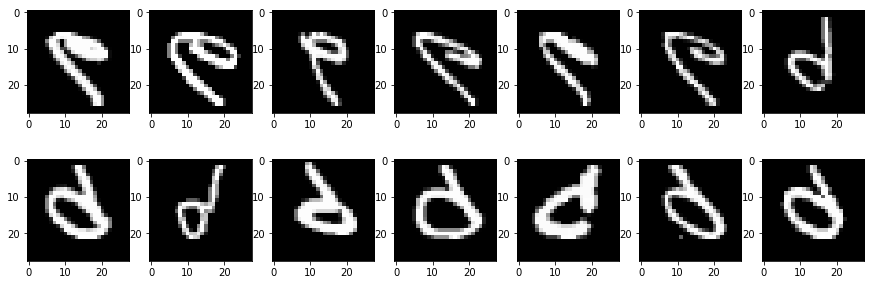

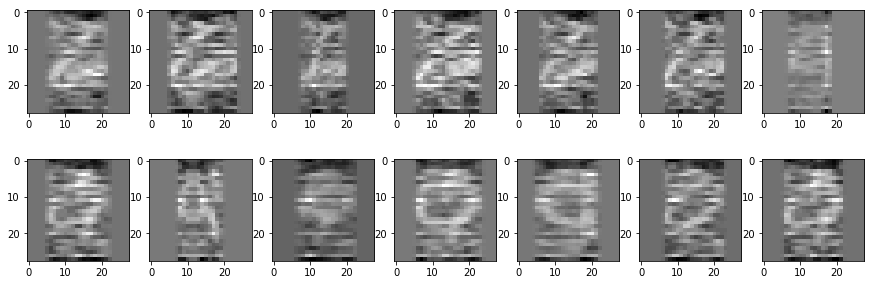

In [25]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    x_flip_permute = sess.run(after_permute_x,feed_dict={x_feed_student:x_flip})
    plt.figure(figsize=(15,5))
    for i in np.arange(2*7):
        plt.subplot(2,7,i+1)
        plt.imshow(x_flip[5411+i][...,0],cmap='gray')
    plt.figure(figsize=(15,5))
    for i in np.arange(2*7):
        plt.subplot(2,7,i+1)
        plt.imshow(x_flip_permute[5411+i][...,0],cmap='gray')
    print(x_flip_permute.shape)